In [18]:
import bs4 as bs
import pandas as pd
import os
import pandas_datareader.data as web
import pickle
import requests
import numpy as np
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from astroML.plotting.tools import draw_ellipse
from sklearn.cluster import KMeans
from datetime import date
from dateutil.relativedelta import relativedelta
from plotly.offline import plot
import plotly.graph_objs as pgo

In [3]:
def save_sp500_tickers():
    #resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    resp = requests.get('https://en.wikipedia.org/wiki/S%26P_100')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text[:-1]
        tickers.append(ticker)
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    return tickers

In [4]:
def get_data_from_yahoo(start_date, end_date, reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = start_date
    end = end_date
    for ticker in tickers:
        # just in case your connection breaks, we'd like to save our progress!
        ticker = ticker.replace('.', '-')
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            try:
                df = web.DataReader(ticker, 'yahoo', start, end)
                df.reset_index(inplace=True)
                df.set_index("Date", inplace=True)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
                print('Create {}'.format(ticker))
            except:
                print('Drop {}'.format(ticker))
                pass
        else:
            print('Already have {}'.format(ticker))

In [5]:
def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        try:
            df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
            df["Name"] = ticker
            df.set_index('Date', inplace=True)
            df.drop(['Adj Close'], axis = 1)

            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.append(df)
        except:
            pass

        if count % 100 == 0:
            print(count)

    print(main_df.head())
    main_df.to_csv('all_stocks_5yr.csv')

In [6]:
end_date = pd.Timestamp(pd.to_datetime('today').strftime("%m/%d/%Y"))
start_date = '01/01/' + str((end_date - relativedelta(years=5)).year)
get_data_from_yahoo(start_date, end_date, reload_sp500=True)
compile_data()

Create AAPL
Create ABBV
Create ABT
Create ACN
Create ADBE
Create AIG
Create AMGN
Create AMT
Create AMZN
Create AVGO
Create AXP
Create BA
Create BAC
Create BIIB
Create BK
Create BKNG
Create BLK
Create BMY
Create BRK-B
Create C
Create CAT
Create CHTR
Create CL
Create CMCSA
Create COF
Create COP
Create COST
Create CRM
Create CSCO
Create CVS
Create CVX
Create DD
Create DHR
Create DIS
Create DOW
Create DUK
Create EMR
Create EXC
Create F
Create FB
Create FDX
Create GD
Create GE
Create GILD
Create GM
Create GOOG
Create GOOGL
Create GS
Create HD
Create HON
Create IBM
Create INTC
Create JNJ
Create JPM
Create KHC
Create KO
Create LIN
Create LLY
Create LMT
Create LOW
Create MA
Create MCD
Create MDLZ
Create MDT
Create MET
Create MMM
Create MO
Create MRK
Create MS
Create MSFT
Create NEE
Create NFLX
Create NKE
Create NVDA
Create ORCL
Create PEP
Create PFE
Create PG
Create PM
Create PYPL
Create QCOM
Create RTX
Create SBUX
Create SO
Create SPG
Create T
Create TGT
Create TMO
Create TMUS
Create TSLA
Cre

In [7]:
def inputvec(data, company, year):
    
    '''
    takes the relevant info from data (company is a string, year is an int)
    generates a 4D vector Q_{i} for the ith quarter
    
    Q_{i} elements:
        v_{i}: standard deviation of opening price
        s_{i}: mean(high price - low price)
        n_{y,i}: mean(traded shares)
        h_{y,i}: mean(high price)
    
    output is concatenation of company, year, Q_{1}, Q_{2}, Q_{3}, and Q_{4}
    '''
    def Q(i, d):
        
        if i == 1:  
            month_strs = ['-01-']
        if i == 2:
            month_strs = ['-02-']
        if i == 3:
            month_strs = ['-03-']
        if i == 4:
            month_strs = ['-04-']
        if i == 5:
            month_strs = ['-05-']
        if i == 6:
            month_strs = ['-06-']
        if i == 7:
            month_strs = ['-07-']
        if i == 8:
            month_strs = ['-08-']
        if i == 9:
            month_strs = ['-09-']
        if i == 10:
            month_strs = ['-10-']
        if i == 11:
            month_strs = ['-11-']
        if i == 12:
            month_strs = ['-12-']
        
        filterquarter = d
        months = [filterquarter.loc[filterquarter['Date'].str.contains(month_str)] for month_str in month_strs]
    
        opens = [month['Open'].tolist() for month in months] 
        opens = [j for i in opens for j in i] #concatenates months
        
        highs = [month['High'].tolist() for month in months]
        highs = [j for i in highs for j in i]
        
        lows = [month['Low'].tolist() for month in months]
        lows = [j for i in lows for j in i]
        
        volumes = [month['Volume'].tolist() for month in months]
        volumes = [j for i in volumes for j in i]
        
        spreads = [highs[i] - lows[i] for i in range(len(highs))]
        
        #ignores NaNs
        
        if len(opens) != 0: #checking if there's actually any data
            mo, mh, ml, mv, ms = max(opens), max(highs), max(lows), max(volumes), max(spreads)
            try:
                opens = [opening/mo for opening in opens]
                highs = [high/mh for high in highs]
                lows = [low/ml for low in lows]
                volumes = [volume/mv for volume in volumes]
                spreads = [spread/ms for spread in spreads]

            except:
                pass
            v, s = np.nanstd(opens), np.nanmean(spreads)
            n, h = np.nanmean(volumes), np.nanmean(highs)
    
        else:
            v, s, n, h = 0, 0, 0, 0
    
        return [v, s, n, h]
    
        #filters out by the company and relevant year
    filter1 = data.loc[data['Name'] == company]
    
    returnList = [company]
    
    for year in years:
        filter2 = filter1.loc[filter1['Date'].str.contains(str(year))]    
        for i in range(1,13):
            returnList.extend(Q(i, filter2))
              
    return returnList

In [8]:
raw = pd.read_csv('all_stocks_5yr.csv')
data = raw.loc[:, ('Date','Open','High','Low','Close','Volume','Name')]
        
companies = data.Name.unique()
        #years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017','2018', '2019', '2020', '2021']
years = ['2016', '2017', '2018', '2019', '2020', '2021']
        
inputvectors = []
for company in companies:
        inputvectors.append(inputvec(data, company, years))

In [9]:
i = len(inputvectors[0])

modifiedStr = '%s'
for x in range(i -1):
    modifiedStr +=  ' %.02f'
modifiedStr+='\n'

with open('inputvector_table.txt', 'w+') as f:
    for item in inputvectors:
        f.write(modifiedStr%(tuple(item)))

In [10]:
def PerformOperation():
    #load and prepare data
    input_vecs = np.array(pd.read_csv("inputvector_table.txt", sep =" ", header =None))
    vectors = input_vecs[:,1:]
    labels = input_vecs[:,:1]
    
    s = len(input_vecs[0]) - 1
    vectors = np.asarray(vectors).astype('float32')
        
    x_train, x_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.33, random_state=1)
        
    x_train = np.asarray(x_train).astype('float32')
    x_test = np.asarray(x_test).astype('float32')
        
    #Setup autoencoder structure
    input_vector = Input(shape=(s,)) #Use 16 floats vector as input
    encoded_1 = Dense(32, activation='selu')(input_vector)
    encoded_2 = Dense(16, activation='selu')(encoded_1)
    middle_layer = Dense(2, activation='elu')(encoded_2)
    decoded_1 = Dense(16, activation='selu')(middle_layer)
    decoded_2 = Dense(32, activation='selu')(decoded_1)
    decoded_output = Dense(s, activation='sigmoid')(decoded_2)
    
    
    autoencoder = Model(input_vector, decoded_output)
    autoencoder.compile(optimizer='rmsprop', loss='mae')
    autoencoder.summary()
        
    #Train the autoencoder
    autoencoder.fit(x_train, x_train,
                        epochs=100, #also used many different epoch values/batch sizes
                        batch_size=8,
                        shuffle=True,
                        validation_data=(x_test, x_test))
        
    autofitted = autoencoder.predict(vectors)
        
    #compare to estimate performance
    autofitted[1]
    x_test[1]
        
    #separate encoder
    encoder = Model(input_vector, middle_layer)
    encoder.compile(optimizer='rmsprop', loss='mae')
        
    #predict encoded vectors from input vectors
    encoded_vecs = encoder.predict(vectors)
        
    #separate decoder
    encoded_vector = Input(shape=(2,))
    deco1 = autoencoder.layers[-3](encoded_vector)
    deco2 = autoencoder.layers[-2](deco1)
    decoout = autoencoder.layers[-1](deco2)
    decoder = Model(encoded_vector, decoout)
        
    #predict decoded vectors from encoded vectors
    decoded_vecs = decoder.predict(encoded_vecs)
        
    #Confirm that separate encoding/decoding does the same as the autoencoder
    np.array_equal(autofitted, decoded_vecs)
        
    #Write labels with corresponding encoded values to file
    output = np.concatenate((labels,encoded_vecs), axis=1)
    np.savetxt("encoded_with_labels.txt", output, fmt='%s', delimiter=',')
    
    
    #LatentSpace = autoencoder.predict(vectors)[0]
    #LatentSpace_noise = autoencoder.predict(vectors)[2]
    #std = np.exp(0.5 * autoencoder.predict(vectors)[1])
    #Reconstruction = autoencoder.predict(vectors)
    #return LatentSpace, LatentSpace_noise, std, Reconstruction


In [11]:
PerformOperation()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 288)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                9248      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 288)               9504  

In [12]:
encodedData = np.array(pd.read_csv('encoded_with_labels.txt', sep = ',', header=None))
encoded_values = encodedData[:,1:3]

In [13]:
def PlotKmeans(encoded_values,y_kmeans, n ):
    
    plt.figure()
    plt.scatter(encoded_values[:, 0], encoded_values[:, 1], c=y_kmeans, s=5, cmap='Dark2')
    #plt.text(encoded_values[:, 0], encoded_values[:, 1], labels, fontsize=8)
    plt.xlabel(r'$x$', fontsize=16)
    plt.ylabel(r'$y$', fontsize=16)
    plt.title(r'$k$-means, $N_{clusters} = %i$'%n, fontsize=16)
    plt.show()

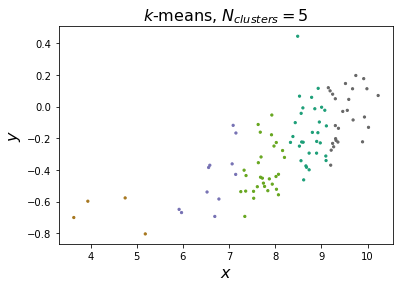

In [14]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(encoded_values)
y_kmeans = kmeans.predict(encoded_values)
#centers = kmeans.cluster_centers_   
PlotKmeans(encoded_values,y_kmeans, 5 )

In [80]:
encodedData = np.array(pd.read_csv('encoded_with_labels.txt', sep = ',', header=None))
encoded_values = encodedData[:,1:3]

# Represent neighborhoods as in previous bubble chart, adding cluster information under color.

trace0 = pgo.Scatter(x=encoded_values[:, 0],
                     y=encoded_values[:, 1],
                     text=encodedData[:, 0],
                     name='',
                     mode='markers+text',
                     marker=pgo.Marker(size=6,
                                       sizemode='diameter',
                                       #sizeref=(encodedData[:, 2]).max()/50,
                                       opacity=0.5,
                                       color=y_kmeans),
                     showlegend=False
)


# Represent cluster centers.
trace1 = pgo.Scatter(x=kmeans.cluster_centers_[:, 0],
                     y=kmeans.cluster_centers_[:, 1],
                     name='',
                     mode='markers',
                     marker=pgo.Marker(symbol='x',
                                       size=12,
                                       color='#9D56D1'),
                     showlegend=False
)

layout = pgo.Layout(title='K-Means with auto-encoder',
                     xaxis=pgo.XAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     yaxis=pgo.YAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     hovermode='closest'
)

data7 = pgo.Data([trace0, trace1])
layout['title'] = 'k-means clustering with 5 clusters'
fig7 = pgo.Figure(data=data7, layout=layout)
plot(fig7, filename='stock-cluster-map')

C:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:434: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.


C:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:544: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


C:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:572: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


C:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data 

'stock-cluster-map.html'

In [15]:
def plot_gmm(firstvar, secondvar, labels, name):
    X = np.vstack([firstvar, secondvar]).T # GaussianMixture requires a 2D array as input
        
    K = np.arange(1, 6)
    models = [None for i in K]
        
    models = [GaussianMixture(K[i], random_state=1, covariance_type='full', \
                  n_init=10).fit(X) for i in range(len(K))]
        
    AIC = [m.aic(X) for m in models]
    BIC = [m.bic(X) for m in models]
    logL = [m.score(X) for m in models]
    for i in range(len(K)):
        print('K = %d  AIC = %.1f  BIC = %.1f  logL = %.3f'%(K[i], AIC[i], BIC[i], logL[i]))
        
    gmm_best = models[np.argmin(AIC)] # choose the best model with smallest AIC
        
    print('mu =', gmm_best.means_.flatten())
    print('sig =', np.sqrt(gmm_best.covariances_.flatten()))
    print('pk =', gmm_best.weights_.flatten())
        
    plt.figure()
        
    plt.scatter(firstvar, secondvar, s=2)
    plt.xlabel(r'$x$', fontsize=20)
    plt.ylabel(r'$y$', fontsize=20)
    plt.title('Gaussian Mixture Model, %s'%(name), fontsize=14)
    plt.tight_layout()
        
    for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
        draw_ellipse(mu, C, scales=[2], fc='none', ec='k')
    
    plt.show()

In [16]:
data = pd.read_csv('encoded_with_labels.txt')

data.columns= ['company', 'x', 'y']

company = data['company'].tolist()

l = [company[i] for i in range(len(company))]
x = data['x'].tolist()
y = data['y'].tolist()

K = 1  AIC = 264.9  BIC = 277.8  logL = -1.287
K = 2  AIC = 247.5  BIC = 276.1  logL = -1.139
K = 3  AIC = 246.9  BIC = 291.1  logL = -1.075
K = 4  AIC = 253.4  BIC = 313.1  logL = -1.047
K = 5  AIC = 244.2  BIC = 319.4  logL = -0.940
mu = [ 9.4316607  -0.07316361  7.67079431 -0.38453664  3.78932589 -0.64916481
  8.81152423 -0.12507176  5.61563312 -0.67090868]
sig = [0.39502029 0.17726256 0.17726256 0.16136341 0.56639484 0.16731089
 0.16731089 0.15904133 0.15216167 0.08857417 0.08857417 0.05157034
 0.28519155        nan        nan 0.19979751 0.64696381        nan
        nan 0.08196122]
pk = [0.28227394 0.41548188 0.02019838 0.23628196 0.04576386]


<ipython-input-15-80f97fb8f483>:19: RuntimeWarning: invalid value encountered in sqrt
  print('sig =', np.sqrt(gmm_best.covariances_.flatten()))


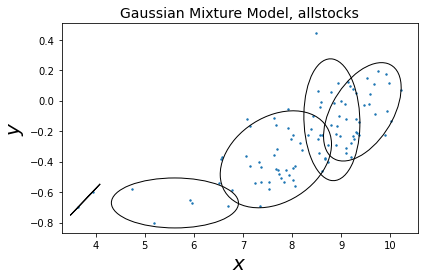

In [17]:
plot_gmm(x,y,l,'allstocks')

In [25]:
import itertools
from scipy import linalg
import math
from sklearn import mixture

In [123]:
color_iter = itertools.cycle(['navy', 'cyan', 'cornflowerblue', 'gold','orange'])
np.set_printoptions(suppress=True)
def plot_results(X, Y_, means, covariances, textData,  title):
    data = []
    #n = pd.DataFrame(textData, columns = ['x', 'y', 'company'])
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):       
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue

        trace = pgo.Scatter(x=X[Y_ == i, 0], y=X[Y_ == i, 1],
                            #text=p,
                            mode='markers',
                            marker=dict(color=color))
        data.append(trace)
        
        # Plot an ellipse to show the Gaussian component
        a =  v[1]
        b =  v[0]
        x_origin = mean[0]
        y_origin = mean[1]
        x_ = [ ]
        y_ = [ ]
    
        for t in range(0,361,10):
            x = a*(math.cos(math.radians(t))) + x_origin
            x_.append(x)
            y = b*(math.sin(math.radians(t))) + y_origin
            y_.append(y)
    
        elle = pgo.Scatter(x=x_ , y=y_, mode='lines',
                          showlegend=False,
                          line=dict(color=color,
                                   width=2))
        data.append(elle)
       
    layout = pgo.Layout(title=title, showlegend=False,
                       xaxis=dict(zeroline=False, showgrid=False),
                       yaxis=dict(zeroline=False, showgrid=False),)
    fig = pgo.Figure(data=data, layout=layout)
    
    return fig

In [124]:
data = pd.read_csv('encoded_with_labels.txt')
 
data.columns= ['company', 'x', 'y']
#data['i'] = [i for i in range(len(data))]

company = data['company'].tolist()

x = data['x'].tolist()
y = data['y'].tolist()
#i = data['i'].tolist()
Y = np.vstack([x, y]).T

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)

fig = plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, d, 'Gaussian Mixture')
plot(fig)

[[ 9.  8.  9.  9.  9.  9.  9.  8.  9.  9.  9.  8.  9.  9.  9.  9.  9.  9.
   9.  9.  9.  8.  9.  9.  9.  9.  9.]
 [-0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0.
   0. -0. -0. -0. -0. -0. -0. -0. -0.]]
[[ 7.  7.  7.  7.  6.  6.  7.]
 [-0. -1. -1. -1. -1. -1. -0.]]
[[ 8.  8.  8.  8.  8.  8.  7.  8.  7.  8.  8.  7.  8.  7.  7.  8.  8.  8.
   8.  8.  8.  8.  7.  8.  7.  7.  8.  8.  8.  8.  8.  7.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -1. -1. -0. -1.
  -0. -1. -0. -0. -0. -0. -0. -1. -1. -0. -0. -1. -1. -1.]]
[[ 9. 10. 10. 10. 10.  9.  9. 10. 10.  9.  9.  9.  9.  9.  9. 10.  9.  9.
   9. 10.  9. 10.  9.  9.  9. 10.  9. 10. 10.]
 [-0. -0.  0.  0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0.
   0. -0. -0.  0.  0. -0. -0.  0.  0. -0. -0.]]
[[ 4.  5.  5.  4.]
 [-1. -1. -1. -1.]]


<ipython-input-123-789ecc5a1eec>:20: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



'temp-plot.html'

In [95]:
data = pd.read_csv('encoded_with_labels.txt')
 
data.columns= ['company', 'x', 'y']

company = data['company'].tolist()

x = data['x'].tolist()
y = data['y'].tolist()
X = np.vstack([x, y]).T

gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
Y_ = gmm.predict(X)
#X = np.vstack([x, y, company]).T

In [96]:
X[Y_ == 1, 0]

array([8.32875347, 8.80280209, 8.59748745, 8.66286182, 8.55963039,
       8.15757847, 8.48500633, 8.43183422, 8.78664017, 8.52452469,
       8.60345554, 7.92494345, 8.19855213, 8.92828846, 9.14802074,
       8.85588741, 8.5221777 , 8.38137722, 8.67607784, 8.61467075,
       8.57138824, 8.55649662])

In [97]:
X[Y_ == 1, 1]

array([-0.22611177, -0.16282529, -0.00816584, -0.37464929, -0.04251343,
       -0.27747107,  0.44451734, -0.10131025,  0.05858228,  0.06604026,
       -0.22500312, -0.05315292, -0.32106239,  0.11535583,  0.11930869,
       -0.01359236, -0.24966443, -0.18895465, -0.38329816, -0.46293098,
       -0.22345221, -0.3418557 ])